# ID/X Partners Data Scientist Project Based Internship
## Final Project

# Loading Libraries

In [25]:
# Data Manipulation
import pandas as pd
import numpy as np
import math

# Progress Bar
from tqdm import tqdm

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
import xgboost as xgb
import catboost as cb
from catboost import Pool
import lightgbm as lgb
from xgboost import XGBRegressor
import pickle

# Evaluation
from sklearn.metrics import mean_squared_error, make_scorer, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict, TimeSeriesSplit, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Optimization
import optuna

# Explainability
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tqdm import tqdm

# Warning
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [26]:
train = pd.read_csv('/kaggle/input/loan-data-rakamin/loan_data_2007_2014.csv')

In [27]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [28]:
train.describe(include='object')

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,...,466285,466264,466285,466285,466256,466285,465909,239071,466243,466285
unique,2,7,35,205475,11,6,3,91,9,2,...,14,63098,888,50,664,2,98,100,103,1
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-14,Current,n,...,debt_consolidation,Debt consolidation,945xx,CA,Oct-00,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,466276,...,274195,164075,5304,71450,3674,303005,179620,208393,327699,466285


In [29]:
train.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,466285.000000,4.662850e+05,4.662850e+05,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,3.960090e+05,0.0,0.0,0.0
mean,233142.000000,1.307973e+07,1.459766e+07,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,...,NaN,NaN,NaN,NaN,NaN,NaN,3.037909e+04,NaN,NaN,NaN
std,134605.029472,1.089371e+07,1.168237e+07,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,...,NaN,NaN,NaN,NaN,NaN,NaN,3.724713e+04,NaN,NaN,NaN
min,0.000000,5.473400e+04,7.047300e+04,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN
25%,116571.000000,3.639987e+06,4.379705e+06,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.350000e+04,NaN,NaN,NaN
50%,233142.000000,1.010790e+07,1.194108e+07,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,...,NaN,NaN,NaN,NaN,NaN,NaN,2.280000e+04,NaN,NaN,NaN
75%,349713.000000,2.073121e+07,2.300154e+07,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,...,NaN,NaN,NaN,NaN,NaN,NaN,3.790000e+04,NaN,NaN,NaN
max,466284.000000,3.809811e+07,4.086083e+07,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,...,NaN,NaN,NaN,NaN,NaN,NaN,9.999999e+06,NaN,NaN,NaN


# Data Preprocessing

## Dropping Irrelevant Columns and Columns with No Values

In [30]:
df = train.copy()

In [31]:
df = df.dropna(axis=1, how='all')

In [32]:
df['member_id'].value_counts()

member_id
11061576    1
1296599     1
1314167     1
1313524     1
1277178     1
           ..
1299699     1
1304884     1
1294539     1
1304855     1
1284848     1
Name: count, Length: 466285, dtype: int64

In [33]:
df['id']

0         1077501
1         1077430
2         1077175
3         1076863
4         1075358
           ...   
466280    8598660
466281    9684700
466282    9584776
466283    9604874
466284    9199665
Name: id, Length: 466285, dtype: int64

Karena length dari 'id' dan 'member_id' sama dengan length dari datasetnya, maka kedua fitur tersebut tidak memberikan informasi apapun yang berguna. Maka dari itu, saya akan menghilangkan kedua kolom tersebut.

In [34]:
df.drop(columns=['member_id', 'id', 'Unnamed: 0', 'url'], inplace=True)

In [35]:
df.describe(include='object')

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,...,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,...,466285,466264,466285,466285,466256,466285,465909,239071,466243,466285
unique,2,7,35,205475,11,6,3,91,9,2,...,14,63098,888,50,664,2,98,100,103,1
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-14,Current,n,...,debt_consolidation,Debt consolidation,945xx,CA,Oct-00,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,466276,...,274195,164075,5304,71450,3674,303005,179620,208393,327699,466285


Ternyata fitur `application_type` juga hanya memiliki 1 kategori. Fitur `zip_code` juga memiliki sangat banyak kategori, sedangkan kita sudah memiliki fitur `addr_state` yang lebih informatif bagi model. Fitur `desc` dan `title` juga memiliki kaitan erat dengan `purpose`, tetapi `dec` dan `title` memiliki lebih banyak kategori dan membutuhkan data cleaning yang lebih banyak, sedangkan kedua fitur tersebut sudah cukup terepresentasikan dengan `purpose`. Maka, kita akan menghilangkan fitur-fitur tersebut.

In [36]:
df['purpose'].value_counts()

purpose
debt_consolidation    274195
credit_card           104157
home_improvement       26537
other                  23690
major_purchase          9828
small_business          7013
car                     5397
medical                 4602
moving                  2994
vacation                2487
wedding                 2343
house                   2269
educational              422
renewable_energy         351
Name: count, dtype: int64

In [37]:
df['title'].value_counts()

title
Debt consolidation                          164075
Credit card refinancing                      62275
Debt Consolidation                           15760
Home improvement                             14849
Other                                        12713
                                             ...  
credit repayment                                 1
medical bills/credit card payoff                 1
One Time Only Relief!                            1
Advertising and business expenses                1
pay-off credit cards/ debt consolidation         1
Name: count, Length: 63098, dtype: int64

Selain itu, fitur `pymnt_plan` sangat imbalanced dengan hanya 9 row yang memiliki kategori 'y', sehingga saya juga akan menghilangkan row tersebut.

In [38]:
# drop irrelevant features
df.drop(columns=['application_type', 'zip_code', 'desc', 'title', 'pymnt_plan'], inplace=True)

## Converting Datetime Columns

Karena format dari kolom-kolom waktu kurang jelas di Data Dictionary, maka saya hanya akan mengambil bulan saja, tidak tahun dan tanggal.

In [39]:
df.describe(include='object')

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d
count,466285,466285,466285,438697,445277,466285,466285,466285,466285,466285,466285,466256,466285,465909,239071,466243
unique,2,7,35,205475,11,6,3,91,9,14,50,664,2,98,100,103
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,Oct-14,Current,debt_consolidation,CA,Oct-00,f,Jan-16,Feb-16,Jan-16
freq,337953,136929,31686,5399,150049,235875,168055,38782,224226,274195,71450,3674,303005,179620,208393,327699


In [40]:
df['issue_d'] = df['issue_d'].str[:3]
df['earliest_cr_line'] = df['earliest_cr_line'].str[:3]
df['last_pymnt_d'] = df['last_pymnt_d'].str[:3]
df['next_pymnt_d'] = df['next_pymnt_d'].str[:3]
df['last_credit_pull_d'] = df['last_credit_pull_d'].str[:3]

In [41]:
# Mapping bulan ke angka
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df['issue_d'] = df['issue_d'].map(month_mapping)
df['earliest_cr_line'] = df['earliest_cr_line'].map(month_mapping)
df['last_pymnt_d'] = df['last_pymnt_d'].map(month_mapping)
df['next_pymnt_d'] = df['next_pymnt_d'].map(month_mapping)
df['last_credit_pull_d'] = df['last_credit_pull_d'].map(month_mapping)

## Label Processing

Untuk penentuan 'target' prediksi dalam penelitian ini, saya akan menggunakan kolom `loan_status` yang sudah diproses lebih lanjut. Pemrosesannya adalah sebagai berikut:

1. **Risky (Risiko Tinggi)**: Charged Off, Default, Late (31-120 days), Late (16-30 days). Status ini merepresentasikan gagal bayar atau keterlambatan yang signifikan.

2. **Non-Risky (Risiko Rendah)**: Fully Paid, Current, In Grace Period. Status ini merepresentasikan keberhasilan atau pinjaman yang masih aktif tanpa masalah besar.

3. **Dikeluarkan dari Analisis**: Does not meet the credit policy. Status ini dapat dihapus karena tidak memberikan informasi final tentang risiko.

In [42]:
# Mengelompokkan loan_status menjadi kategori biner (Risky/Non-Risky)
def classify_loan_status(status):
    if status in ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)']:
        return 'Risky'
    elif status in ['Fully Paid', 'Current', 'In Grace Period']:
        return 'Non-Risky'
    else:
        return None  # Untuk status yang tidak relevan

# Buat kolom baru
df['loan_risk'] = df['loan_status'].apply(classify_loan_status)

# Hapus baris dengan None (opsional, jika ingin fokus pada kategori biner)
df = df[df['loan_risk'].notnull()]

# Cek distribusi target
print(df['loan_risk'].value_counts())

loan_risk
Non-Risky    412111
Risky         51425
Name: count, dtype: int64


In [43]:
loan_risk_mapping = {
    'Risky': 1,
    'Non-Risky': 0
}

df['loan_risk'] = df['loan_risk'].map(loan_risk_mapping)

In [44]:
df.drop(columns=['loan_status'], inplace=True)

# EDA

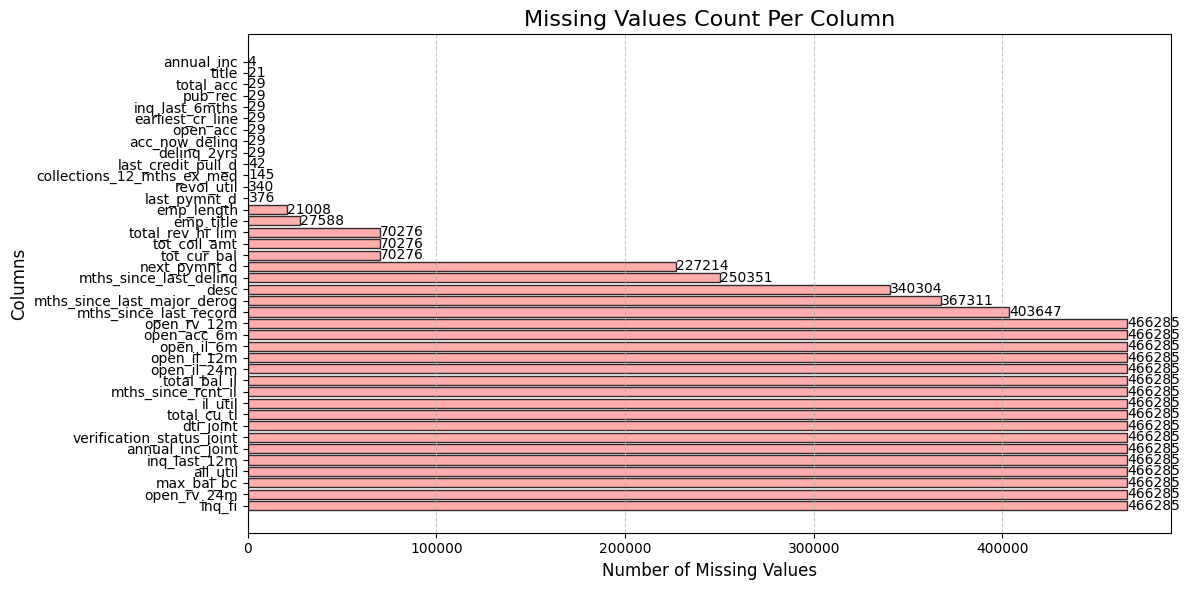

In [103]:
def plot_missing_values(df):
    # Hitung jumlah missing values per kolom
    missing_counts = df.isnull().sum()
    
    # Pilih hanya kolom yang memiliki missing values
    missing_counts = missing_counts[missing_counts > 0].sort_values(ascending=False)
    
    # Plot jika ada missing values
    if not missing_counts.empty:
        plt.figure(figsize=(12, 6))
        bars = plt.barh(missing_counts.index, missing_counts.values, color="#FF9999", edgecolor='black', alpha=0.8)
        
        # Tambahkan label nilai di setiap bar
        for bar in bars:
            plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                     f'{int(bar.get_width())}', va='center', fontsize=10, color='black')
        
        plt.title('Missing Values Count Per Column', fontsize=16)
        plt.xlabel('Number of Missing Values', fontsize=12)
        plt.ylabel('Columns', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("Tidak ada missing values dalam DataFrame.")

plot_missing_values(train)

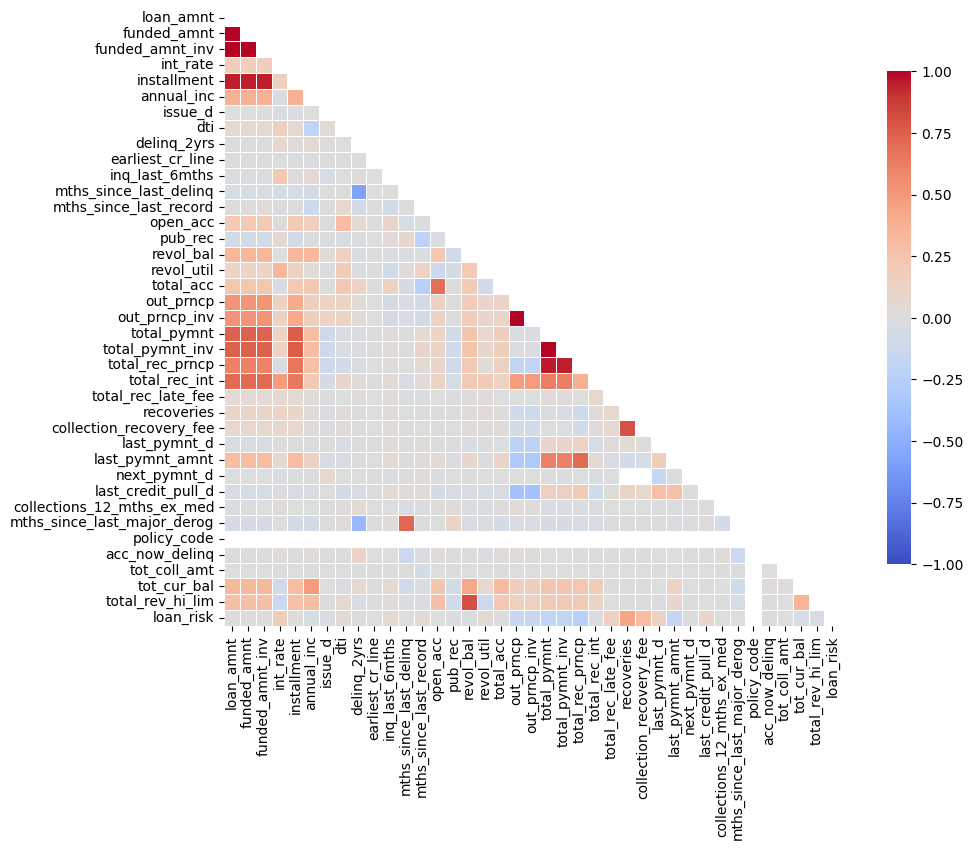

In [45]:
# Compute the correlation matrix
numeric = [col for col in df.columns if df[col].dtype != 'object']
corr = df[numeric].corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f", 
            annot_kws={"size": 8}, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.show()

In [46]:
# Group by each time-related column and calculate mean for selected features
time_related_columns = ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'earliest_cr_line']
features_to_analyze = ['loan_amnt', 'int_rate', 'installment', 'revol_bal']

trend_analysis = {}
for time_col in time_related_columns:
    trend_analysis[time_col] = df.groupby(time_col)[features_to_analyze].mean()

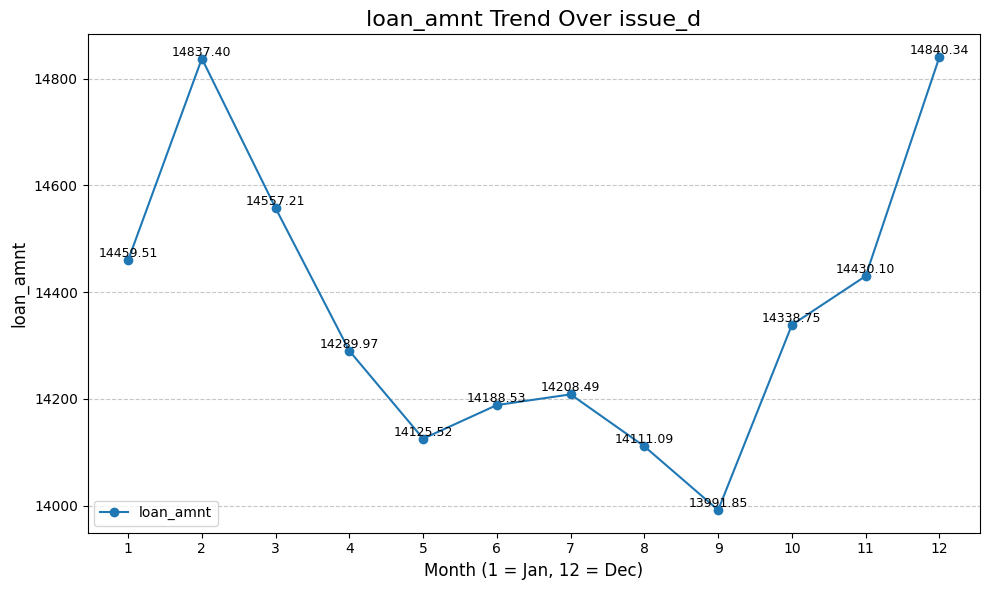

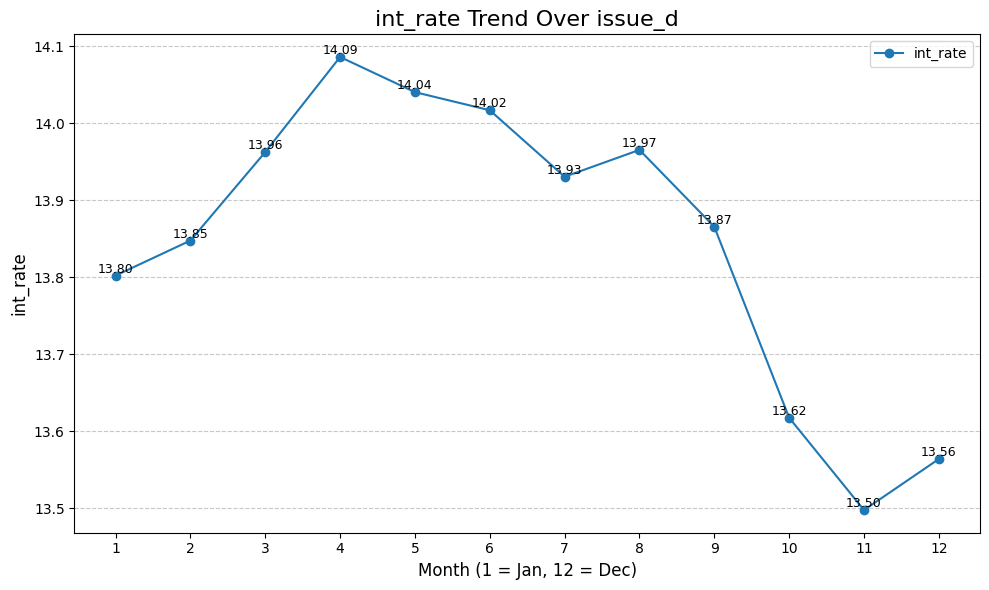

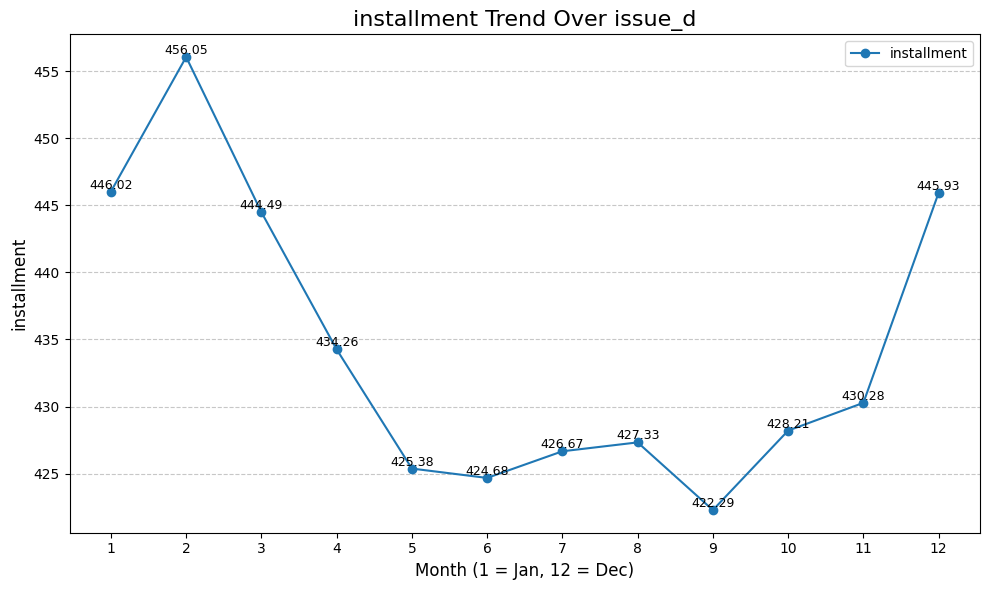

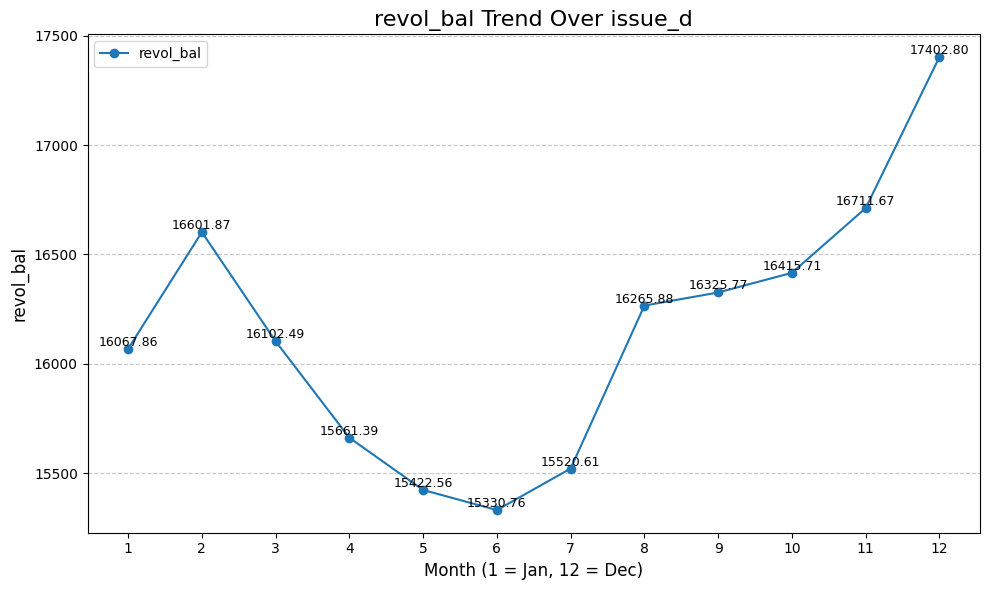

In [47]:
def plot_line_trend_with_values(data, time_col, features):

    all_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Map months to numeric values
    month_mapping = {month: idx + 1 for idx, month in enumerate(all_months)}
    data = data.rename(index=month_mapping).sort_index()

    for feature in features:
        plt.figure(figsize=(10, 6))
        plt.plot(data.index, data[feature], marker='o', label=feature)
        plt.title(f'{feature} Trend Over {time_col}', fontsize=16)
        plt.xlabel('Month (1 = Jan, 12 = Dec)', fontsize=12)
        plt.ylabel(feature, fontsize=12)
        plt.xticks(ticks=range(1, 13), labels=range(1, 13))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Annotate exact values on each point
        for x, y in zip(data.index, data[feature]):
            plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=9, color='black')
        
        plt.legend()
        plt.tight_layout()
        plt.show()

# Example usage with 'issue_d' column
plot_line_trend_with_values(trend_analysis['issue_d'], 'issue_d', features_to_analyze)

# Feature Engineering

## Encoding

In [48]:
df.describe(include='object')

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,addr_state,initial_list_status
count,463536,463536,463536,436107,442562,463536,463536,463536,463536,463536
unique,2,7,35,203964,11,6,3,14,50,2
top,36 months,B,B3,Teacher,10+ years,MORTGAGE,Verified,debt_consolidation,CA,f
freq,335515,136575,31613,5399,149579,234619,167428,273095,71126,300256


In [49]:
df['loan_risk'].value_counts()

loan_risk
0    412111
1     51425
Name: count, dtype: int64

## Ordinal Encoding

Fitur-fitur yang akan diterapkan ordinal encoding adalah:
- `term`
- `grade`
- `sub_grade`
- `emp_length`
- `verification_status`

In [50]:
term_mapping = {
    ' 36 months': 0,
    ' 60 months': 1,
}

grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
grade_mapping = {grade: idx + 1 for idx, grade in enumerate(grades)}

sub_grade_mapping = {'B2': 2, 'C4': 4, 'C5': 5, 'C1': 1, 'B5': 5, 'A4': 4, 'E1': 1, 'F2': 2, 
 'C3': 3, 'B1': 1, 'D1': 1, 'A1': 1, 'B3': 3, 'B4': 4, 'C2': 2, 'D2': 2, 
 'A3': 3, 'A5': 5, 'D5': 5, 'A2': 2, 'E4': 4, 'D3': 3, 'D4': 4, 'F3': 3, 
 'E3': 3, 'F4': 4, 'F1': 1, 'E5': 5, 'G4': 4, 'E2': 2, 'G3': 3, 'G2': 2, 
 'G1': 1, 'F5': 5, 'G5': 5}

emp_length_mapping = {
    '10+ years': 10,
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    None: -1  
}

verification_mapping = {
    'Not Verified': 0,
    'Verified': 1,
    'Source Verified': 2
}

# Terapkan mapping
df['verification_status'] = df['verification_status'].map(verification_mapping)
df['term'] = df['term'].map(term_mapping)
df['grade'] = df['grade'].map(grade_mapping)
df['sub_grade'] = df['sub_grade'].map(sub_grade_mapping)
df['emp_length'] = df['emp_length'].map(emp_length_mapping)

In [51]:
df[['term', 'grade', 'sub_grade', 'emp_length']]

,term,grade,sub_grade,emp_length
0,0,2,2,10.0
1,1,3,4,0.0
2,0,3,5,10.0
3,0,3,1,10.0
4,1,2,5,1.0
...,...,...,...,...
466280,1,3,2,4.0
466281,1,4,5,10.0
466282,1,4,1,7.0
466283,0,1,4,3.0


## Target Encoding

Fitur-fitur yang akan diterapkan target encoding adalah:
- `home_ownership`
- `purpose`
- `addr_state`
- `initial_list_status`

In [52]:
train['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [53]:
purpose_mapping = {
    'credit_card': 'Debt',
    'debt_consolidation': 'Debt',
    'car': 'Purchase',
    'home_improvement': 'Purchase',
    'major_purchase': 'Purchase',
    'house': 'Purchase',
    'wedding': 'Personal',
    'vacation': 'Personal',
    'moving': 'Personal',
    'educational': 'Education/Business',
    'small_business': 'Education/Business',
    'medical': 'Medical',
    'renewable_energy': 'Other',
    'other': 'Other'
}

# Terapkan mapping ke kolom purpose
df['purpose'] = df['purpose'].map(purpose_mapping)

In [54]:
# Fungsi untuk target encoding
def target_encode(df, feature_col, target_col):
    mean_encoding = df.groupby(feature_col)[target_col].mean()
    encoded_col = df[feature_col].map(mean_encoding)
    return encoded_col

In [55]:
df['home_ownership'] = target_encode(df, 'home_ownership', 'loan_risk')
df['purpose'] = target_encode(df, 'purpose', 'loan_risk')
df['addr_state'] = target_encode(df, 'addr_state', 'loan_risk')
df['initial_list_status'] = target_encode(df, 'initial_list_status', 'loan_risk')

In [56]:
df[['home_ownership', 'purpose', 'addr_state', 'initial_list_status']]

,home_ownership,purpose,addr_state,initial_list_status
0,0.127653,0.107916,0.112747,0.121100
1,0.127653,0.099252,0.104768,0.121100
2,0.127653,0.213181,0.094720,0.121100
3,0.127653,0.138520,0.115007,0.121100
4,0.127653,0.138520,0.101652,0.121100
...,...,...,...,...
466280,0.097601,0.107916,0.097468,0.092259
466281,0.097601,0.107916,0.114425,0.121100
466282,0.097601,0.107916,0.110149,0.121100
466283,0.110653,0.107916,0.115007,0.092259


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463536 entries, 0 to 466284
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    463536 non-null  int64  
 1   funded_amnt                  463536 non-null  int64  
 2   funded_amnt_inv              463536 non-null  float64
 3   term                         463536 non-null  int64  
 4   int_rate                     463536 non-null  float64
 5   installment                  463536 non-null  float64
 6   grade                        463536 non-null  int64  
 7   sub_grade                    463536 non-null  int64  
 8   emp_title                    436107 non-null  object 
 9   emp_length                   442562 non-null  float64
 10  home_ownership               463536 non-null  float64
 11  annual_inc                   463536 non-null  float64
 12  verification_status          463536 non-null  int64  
 13  issu

## Regarding `emp_title`

`emp_title` memiliki kardinalitas yang sangat besar dengan lebih dari 170k kategori yang hanya muncul sekali saja. Sulit untuk melakukan cleaning pada bagian ini, sehingga saya memutuskan untuk menghilangkan kolom tersebut saja.

In [58]:
df['emp_title'] = df['emp_title'].fillna("Other")

In [59]:
df['emp_title'].nunique()

203964

In [60]:
# Hitung frekuensi setiap kategori
title_counts = df['emp_title'].value_counts()

# Filter kategori dengan kardinalitas 1
unique_titles = title_counts[title_counts >= 500].index.tolist()

print(len(unique_titles))
print(unique_titles)

41
['Other', 'Teacher', 'Manager', 'Registered Nurse', 'RN', 'Supervisor', 'Sales', 'Project Manager', 'Owner', 'Office Manager', 'manager', 'Driver', 'General Manager', 'Director', 'teacher', 'Engineer', 'driver', 'Vice President', 'President', 'owner', 'Administrative Assistant', 'Operations Manager', 'Attorney', 'Accountant', 'supervisor', 'Police Officer', 'sales', 'Sales Manager', 'Account Manager', 'Executive Assistant', 'Store Manager', 'truck driver', 'US Army', 'Analyst', 'Technician', 'Nurse', 'Software Engineer', 'Truck Driver', 'Assistant Manager', 'Paralegal', 'Controller']


In [61]:
# Hitung frekuensi setiap nilai di kolom emp_title
title_counts = df['emp_title'].value_counts()

# Cek nilai yang muncul kurang dari atau sama dengan 500 kali
to_replace = title_counts[title_counts <= 1].index

# Output jumlah kategori yang akan diganti
print(f"Jumlah kategori yang akan diganti: {len(to_replace)}")

Jumlah kategori yang akan diganti: 171334


In [62]:
df.drop(columns=['emp_title'], inplace=True)

## Interaction Features

In [63]:
df['dti'].value_counts()

dti
14.40    408
19.20    376
12.00    366
18.00    365
16.80    365
        ... 
39.30      2
39.14      1
39.94      1
35.54      1
38.95      1
Name: count, Length: 3997, dtype: int64

In [64]:
df['delinq_2yrs'].value_counts()

delinq_2yrs
0.0     380649
1.0      55938
2.0      16227
3.0       5661
4.0       2368
5.0       1231
6.0        626
7.0        344
8.0        176
9.0        111
10.0        65
11.0        40
12.0        38
13.0        24
14.0         8
15.0         7
18.0         6
16.0         5
17.0         3
19.0         3
22.0         2
21.0         2
24.0         1
29.0         1
Name: count, dtype: int64

In [65]:
df['loan_to_income'] = df['loan_amnt'] / df['annual_inc']
df['funded_utilization'] = df['funded_amnt'] / df['funded_amnt_inv']
df['credit_utilization'] = df['revol_bal'] / df['total_rev_hi_lim']
df['installment_to_income'] = df['installment'] / (df['annual_inc'] / 12)
df['total_pymnt_ratio'] = df['total_pymnt'] / df['loan_amnt']
df['recovery_rate'] = df['recoveries'] / df['loan_amnt']
df['combined_grade'] = df['grade'] * 10 + df['sub_grade']
df['loan_rate_interaction'] = df['loan_amnt'] * df['int_rate']

In [66]:
dti_bins = [0, 10, 20, 30, 40, 50]
dti_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

# Binning DTI
df['dti_category'] = pd.cut(df['dti'], bins=dti_bins, labels=dti_labels, right=False)

In [67]:
# Tentukan bins untuk delinq_2yrs
delinq_bins = [-1, 0, 2, 5, float('inf')]  # -1 untuk menangkap nilai 0 secara tepat
delinq_labels = ['No Delinquency', 'Low', 'Moderate', 'High']

# Binning delinq_2yrs
df['delinq_category'] = pd.cut(df['delinq_2yrs'], bins=delinq_bins, labels=delinq_labels, right=False)

In [68]:
# Mapping ordinal untuk dti_category
dti_ordinal_mapping = {
    'Very Low': 0,
    'Low': 1,
    'Moderate': 2,
    'High': 3,
    'Very High': 4
}

# Terapkan mapping
df['dti_category'] = df['dti_category'].map(dti_ordinal_mapping).astype(int)

In [69]:
delinq_ordinal_mapping = {
    'No Delinquency': 0,
    'Low': 1,
    'Moderate': 2,
    'High': 3
}

# Terapkan mapping
df['delinq_category'] = df['delinq_category'].map(delinq_ordinal_mapping).astype(int)

## Time Cyclical Features

In [70]:
time_features = ['issue_d', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line']
df[time_features]

,issue_d,last_pymnt_d,next_pymnt_d,last_credit_pull_d,earliest_cr_line
0,12,1.0,NaN,1.0,1.0
1,12,4.0,NaN,9.0,4.0
2,12,6.0,NaN,1.0,11.0
3,12,1.0,NaN,1.0,2.0
4,12,1.0,2.0,1.0,1.0
...,...,...,...,...,...
466280,1,1.0,2.0,1.0,4.0
466281,1,12.0,NaN,1.0,6.0
466282,1,1.0,2.0,12.0,12.0
466283,1,12.0,NaN,4.0,2.0


In [71]:
for col in time_features:
    # Pastikan kolom tidak memiliki nilai NaN sebelum encoding
    df[col] = df[col].fillna(0)  # Atau Anda bisa mengganti 0 dengan nilai default lain
    # Lakukan cyclical encoding
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / 12)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / 12)

# Clustering

In [72]:
df = df.replace([np.inf, -np.inf], np.nan)
df.fillna(-1, inplace=True)

In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df) 

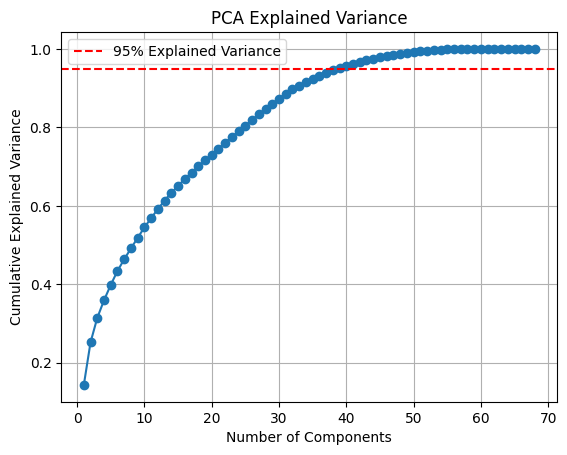

Number of components to retain 95% variance: 39


In [74]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA tanpa mengurangi jumlah komponen
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Hitung cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualisasi explained variance
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid()
plt.show()

# Pilih jumlah komponen untuk 90% variance
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

In [75]:
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled)

In [76]:
print(f"Number of components selected: {X_reduced.shape[1]}")

Number of components selected: 39


In [77]:
from sklearn.cluster import KMeans

# Elbow Method untuk menentukan jumlah cluster optimal
inertia = []
cluster_range = range(2, 11)

# Gunakan tqdm untuk memantau progress
for k in tqdm(cluster_range, desc="Elbow Method Progress"):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    inertia.append(kmeans.inertia_)

Elbow Method Progress: 100%|██████████| 9/9 [01:29<00:00,  9.94s/it]


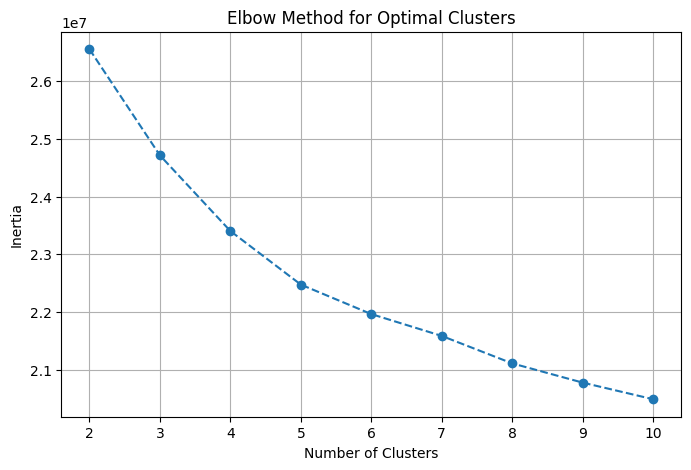

In [78]:
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.grid()
plt.show()

In [81]:
# Tentukan jumlah cluster optimal, misalnya k_optimal = 4 (hasil dari Elbow Method)
k_optimal = 4

# Inisialisasi dan fit ulang model KMeans
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(X_reduced)

# Tambahkan hasil clustering sebagai kolom baru di DataFrame
df['cluster'] = kmeans.labels_

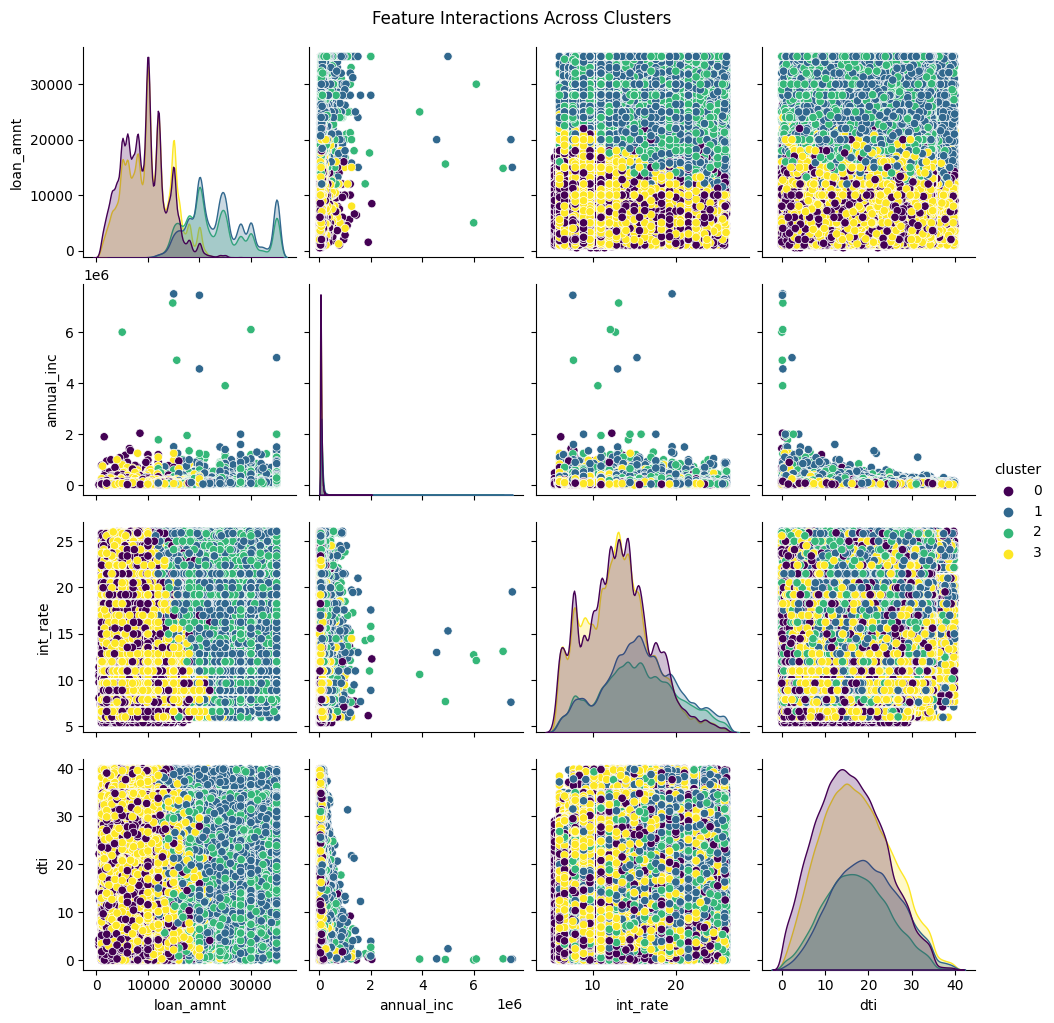

In [82]:
# Hanya gunakan fitur numerik untuk pairplot
numerical_features = ['loan_amnt', 'annual_inc', 'int_rate', 'dti']

# Pastikan data numerik tidak memiliki nilai yang tidak valid
numerical_data = df[numerical_features + ['cluster']].select_dtypes(include=[np.number])

# Pairplot untuk fitur numerik
sns.pairplot(numerical_data, hue='cluster', vars=numerical_features, diag_kind='kde', palette='viridis')
plt.suptitle("Feature Interactions Across Clusters", y=1.02)
plt.show()

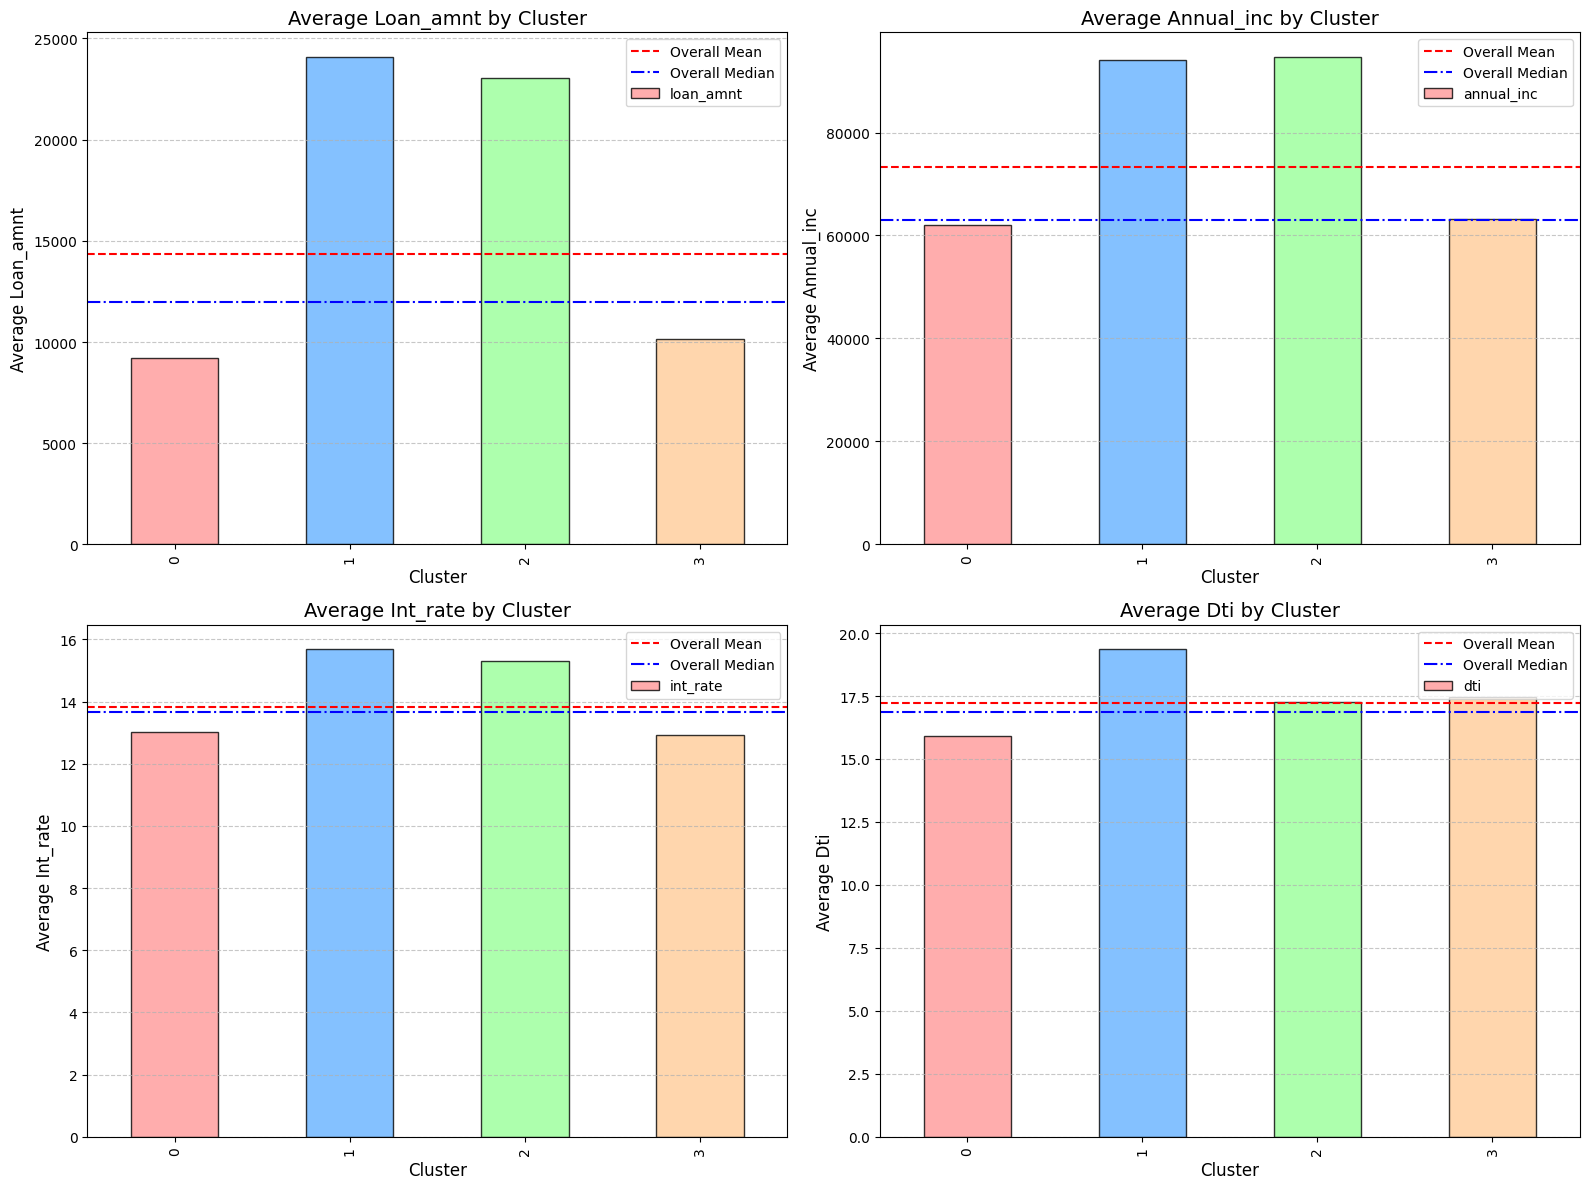

In [84]:
# Fitur yang ingin dibandingkan antar cluster
features_to_compare = ['loan_amnt', 'annual_inc', 'int_rate', 'dti']
cluster_means = df.groupby('cluster')[features_to_compare].mean()

plt.figure(figsize=(16, 12))
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']  # Different colors for clusters

for i, feature in enumerate(features_to_compare, 1):
    plt.subplot(2, 2, i)
    bar = cluster_means[feature].plot(kind='bar', color=colors, edgecolor='black', alpha=0.8)
    
    # Add mean and median lines
    overall_mean = df[feature].mean()
    overall_median = df[feature].median()
    plt.axhline(overall_mean, color='red', linestyle='--', label='Overall Mean')
    plt.axhline(overall_median, color='blue', linestyle='-.', label='Overall Median')
    
    plt.title(f"Average {feature.capitalize()} by Cluster", fontsize=14)
    plt.xlabel("Cluster", fontsize=12)
    plt.ylabel(f"Average {feature.capitalize()}", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Fillna

In [85]:
df.fillna(-1, inplace=True)

# Modelling

In [86]:
X = df.drop(columns=['loan_risk']).copy()
y = df['loan_risk']

In [87]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 463536 entries, 0 to 466284
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    463536 non-null  int64  
 1   funded_amnt                  463536 non-null  int64  
 2   funded_amnt_inv              463536 non-null  float64
 3   term                         463536 non-null  int64  
 4   int_rate                     463536 non-null  float64
 5   installment                  463536 non-null  float64
 6   grade                        463536 non-null  int64  
 7   sub_grade                    463536 non-null  int64  
 8   emp_length                   463536 non-null  float64
 9   home_ownership               463536 non-null  float64
 10  annual_inc                   463536 non-null  float64
 11  verification_status          463536 non-null  int64  
 12  issue_d                      463536 non-null  int64  
 13  purp

In [88]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Hitung class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# Konversi ke dictionary
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y), class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.5623921710412971, 1: 4.50691298006806}


In [89]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

# Dictionary dengan classifier
classifiers = {
    "CatBoost": CatBoostClassifier(class_weights=list(class_weights), verbose=0, task_type="GPU", devices='0'),
    "XGBoost": XGBClassifier(scale_pos_weight=class_weights_dict[1] / class_weights_dict[0], use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist', predictor='gpu_predictor'),
    "LightGBM": LGBMClassifier(class_weight=class_weights_dict, verbose=-1, device='gpu'),  # LightGBM menerima dictionary class weights
    "LogisticRegression": LogisticRegression(class_weight='balanced', max_iter=1000)  # balanced menghitung otomatis
}

In [90]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}  # Store results for each model
for model_name, model in classifiers.items():
    print(f"Training {model_name}...")
    fold_metrics = {"accuracy": [], "f1_macro": [], "recall": [], "precision": []}
    
    for fold, (train_idx, test_idx) in enumerate(tqdm(kf.split(X, y), total=kf.get_n_splits(), desc=f"{model_name} Training")):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Tangani nilai inf atau NaN
        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(-1)
        X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(-1)
        
        # Normalize data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)  # Fit and transform training data
        X_test = scaler.transform(X_test)       # Transform testing data
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred = model.predict(X_test)
        
        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        precision = precision_score(y_test, y_pred, average='macro')
        
        # Append metrics
        fold_metrics["accuracy"].append(accuracy)
        fold_metrics["f1_macro"].append(f1)
        fold_metrics["recall"].append(recall)
        fold_metrics["precision"].append(precision)
        
        # Print fold results
        print(f"Fold {fold+1}: Accuracy={accuracy:.4f}, F1-macro={f1:.4f}, Recall={recall:.4f}, "
              f"Precision={precision:.4f}")
    
    # Compute mean metrics
    mean_metrics = {metric: np.mean(scores) for metric, scores in fold_metrics.items()}
    results[model_name] = mean_metrics
    
    # Print mean results for the model
    print(f"\n{model_name} Mean Metrics:")
    for metric, score in mean_metrics.items():
        print(f"{metric.capitalize()}: {score:.4f}")
    print("-" * 50)

# Summary of all models
print("\nSummary of Mean Metrics for All Models:")
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric, score in metrics.items():
        print(f"  {metric.capitalize()}: {score:.4f}")

Training CatBoost...


CatBoost Training:  20%|██        | 1/5 [00:25<01:43, 25.92s/it]

Fold 1: Accuracy=0.9913, F1-macro=0.9779, Recall=0.9751, Precision=0.9807


CatBoost Training:  40%|████      | 2/5 [00:35<00:49, 16.50s/it]

Fold 2: Accuracy=0.9911, F1-macro=0.9775, Recall=0.9768, Precision=0.9781


CatBoost Training:  60%|██████    | 3/5 [00:45<00:26, 13.45s/it]

Fold 3: Accuracy=0.9907, F1-macro=0.9763, Recall=0.9755, Precision=0.9771


CatBoost Training:  80%|████████  | 4/5 [00:55<00:11, 11.98s/it]

Fold 4: Accuracy=0.9907, F1-macro=0.9765, Recall=0.9761, Precision=0.9768


CatBoost Training: 100%|██████████| 5/5 [01:05<00:00, 13.05s/it]


Fold 5: Accuracy=0.9905, F1-macro=0.9759, Recall=0.9754, Precision=0.9764

CatBoost Mean Metrics:
Accuracy: 0.9909
F1_macro: 0.9768
Recall: 0.9758
Precision: 0.9778
--------------------------------------------------
Training XGBoost...


XGBoost Training:  20%|██        | 1/5 [00:03<00:15,  3.87s/it]

Fold 1: Accuracy=0.9925, F1-macro=0.9808, Recall=0.9767, Precision=0.9850


XGBoost Training:  40%|████      | 2/5 [00:07<00:10,  3.53s/it]

Fold 2: Accuracy=0.9928, F1-macro=0.9816, Recall=0.9791, Precision=0.9841


XGBoost Training:  60%|██████    | 3/5 [00:10<00:06,  3.40s/it]

Fold 3: Accuracy=0.9925, F1-macro=0.9809, Recall=0.9774, Precision=0.9845


XGBoost Training:  80%|████████  | 4/5 [00:13<00:03,  3.34s/it]

Fold 4: Accuracy=0.9919, F1-macro=0.9793, Recall=0.9770, Precision=0.9816


XGBoost Training: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]


Fold 5: Accuracy=0.9922, F1-macro=0.9801, Recall=0.9773, Precision=0.9830

XGBoost Mean Metrics:
Accuracy: 0.9924
F1_macro: 0.9806
Recall: 0.9775
Precision: 0.9837
--------------------------------------------------
Training LightGBM...


LightGBM Training:  20%|██        | 1/5 [00:09<00:39,  9.93s/it]

Fold 1: Accuracy=0.9917, F1-macro=0.9787, Recall=0.9766, Precision=0.9809


LightGBM Training:  40%|████      | 2/5 [00:15<00:22,  7.38s/it]

Fold 2: Accuracy=0.9914, F1-macro=0.9783, Recall=0.9784, Precision=0.9782


LightGBM Training:  60%|██████    | 3/5 [00:21<00:13,  6.62s/it]

Fold 3: Accuracy=0.9915, F1-macro=0.9784, Recall=0.9778, Precision=0.9790


LightGBM Training:  80%|████████  | 4/5 [00:26<00:06,  6.25s/it]

Fold 4: Accuracy=0.9908, F1-macro=0.9767, Recall=0.9773, Precision=0.9762


LightGBM Training: 100%|██████████| 5/5 [00:32<00:00,  6.50s/it]


Fold 5: Accuracy=0.9911, F1-macro=0.9775, Recall=0.9773, Precision=0.9777

LightGBM Mean Metrics:
Accuracy: 0.9913
F1_macro: 0.9779
Recall: 0.9775
Precision: 0.9784
--------------------------------------------------
Training LogisticRegression...


LogisticRegression Training:  20%|██        | 1/5 [00:38<02:33, 38.43s/it]

Fold 1: Accuracy=0.9886, F1-macro=0.9709, Recall=0.9702, Precision=0.9717


LogisticRegression Training:  40%|████      | 2/5 [01:17<01:56, 38.78s/it]

Fold 2: Accuracy=0.9886, F1-macro=0.9711, Recall=0.9730, Precision=0.9693


LogisticRegression Training:  60%|██████    | 3/5 [01:57<01:18, 39.15s/it]

Fold 3: Accuracy=0.9884, F1-macro=0.9706, Recall=0.9717, Precision=0.9694


LogisticRegression Training:  80%|████████  | 4/5 [02:31<00:37, 37.41s/it]

Fold 4: Accuracy=0.9879, F1-macro=0.9695, Recall=0.9713, Precision=0.9676


LogisticRegression Training: 100%|██████████| 5/5 [03:05<00:00, 37.10s/it]

Fold 5: Accuracy=0.9881, F1-macro=0.9699, Recall=0.9710, Precision=0.9689

LogisticRegression Mean Metrics:
Accuracy: 0.9883
F1_macro: 0.9704
Recall: 0.9715
Precision: 0.9694
--------------------------------------------------

Summary of Mean Metrics for All Models:
CatBoost:
  Accuracy: 0.9909
  F1_macro: 0.9768
  Recall: 0.9758
  Precision: 0.9778
XGBoost:
  Accuracy: 0.9924
  F1_macro: 0.9806
  Recall: 0.9775
  Precision: 0.9837
LightGBM:
  Accuracy: 0.9913
  F1_macro: 0.9779
  Recall: 0.9775
  Precision: 0.9784
LogisticRegression:
  Accuracy: 0.9883
  F1_macro: 0.9704
  Recall: 0.9715
  Precision: 0.9694


# Model Interpretation

In [104]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Mengembalikan menjadi DataFrame dengan nama fitur asli
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

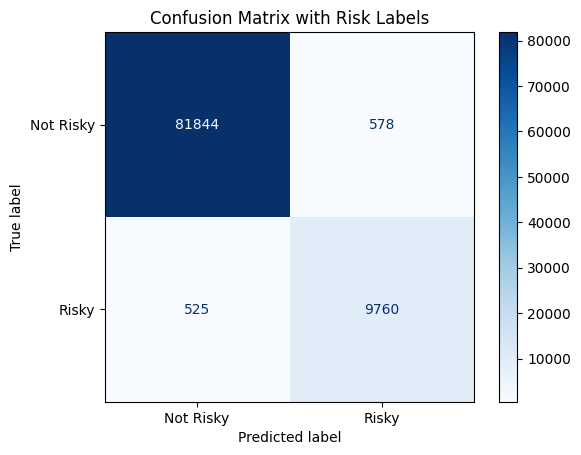

In [109]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

final_model = classifiers['XGBoost']
final_model.fit(X_train, y_train)

# Prediksi pada data test
y_pred = model.predict(X_test)

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Tetapkan label kelas yang sesuai
labels = sorted(set(y))  # Ambil semua kelas unik di y

# Menambahkan label "Risky" dan "Not Risky" untuk kelas
labels = ["Not Risky", "Risky"]  # 0 = Not Risky, 1 = Risky

# Tampilkan confusion matrix dengan label tersebut
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix with Risk Labels")
plt.show()

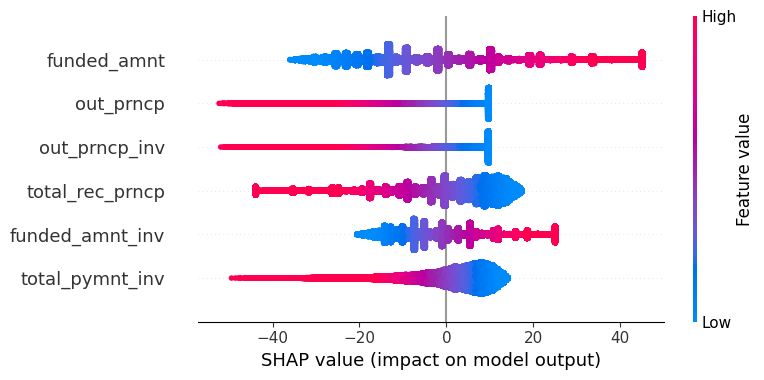

In [106]:
import shap

# Buat Explainer SHAP
explainer = shap.Explainer(model, X_scaled_df)

# Hitung SHAP values
shap_values = explainer(X_scaled_df)

# Plot summary SHAP values
shap.summary_plot(shap_values, X_scaled_df, max_display=6)